In [20]:
import qspectra as qs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
H_electronic = np.array([[11500, 66], [66, 11650]])
n_vibrational_levels = np.array([2, 2])
vib_energies = np.array([200, 200])
elec_vib_couplings = -32 * np.eye(2)
bath = qs.DebyeBath(qs.CM_K * 77, 1.5 * 35, 106)
dipoles = [[1,0,0], [0,1,0]]

dimer_ham = qs.VibronicHamiltonian(
    qs.ElectronicHamiltonian(H_electronic, dipoles=dipoles, bath=bath),
    n_vibrational_levels, vib_energies, elec_vib_couplings)
dimer = qs.RedfieldModel(dimer_ham, hilbert_subspace='gef', unit_convert=qs.CM_FS,
                      discard_imag_corr=True)

## Excited state dynamics

In [22]:
%%time 
t, rho = qs.simulate_dynamics(dimer, qs.unit_vec(0, 2 * 2 ** 2), 1000)

CPU times: user 101 ms, sys: 10.2 ms, total: 111 ms
Wall time: 272 ms


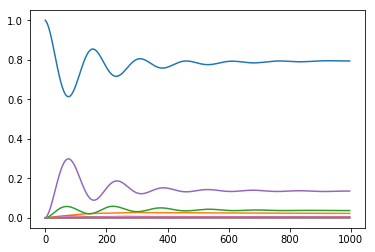

In [23]:
plt.plot(t, np.einsum('tii->ti', rho.reshape(-1, 8, 8)).real);

## Absorption spectra

In [24]:
%%time
f, X = qs.absorption_spectra(dimer, 10000)

CPU times: user 192 ms, sys: 28.9 ms, total: 221 ms
Wall time: 497 ms


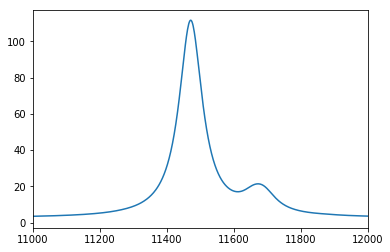

In [25]:
plt.plot(f, X)
plt.xlim(11000, 12000);

## Monomer absorption spectra (for reference)

In [26]:
monomer_ham = qs.VibronicHamiltonian(
    qs.ElectronicHamiltonian(H_electronic[:1, :1], dipoles=dipoles[:1], bath=bath),
    n_vibrational_levels[:1], vib_energies[:1], elec_vib_couplings[:1, :1])
monomer = qs.RedfieldModel(monomer_ham, hilbert_subspace='ge', unit_convert=qs.CM_FS)

In [27]:
%%time
f, X = qs.absorption_spectra(monomer, 10000)

CPU times: user 77.6 ms, sys: 2.94 ms, total: 80.5 ms
Wall time: 139 ms


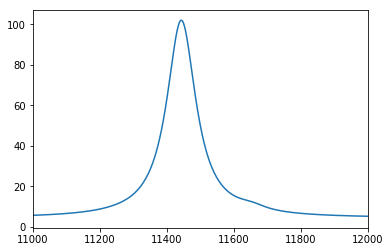

In [28]:
plt.plot(f, X)
plt.xlim(11000, 12000);

## 2D spectra

In [29]:
%%time
(t1, t2, t3), X = qs.third_order_response(dimer, coherence_time_max=1000,
                                          population_times=np.linspace(0, 1000, num=100),
                                          geometry='-++', polarization='xxxx',
                                          include_signal='GSB', exact_isotropic_average=True)

CPU times: user 31 s, sys: 3.27 s, total: 34.2 s
Wall time: 54.4 s


In [30]:
%%time
f1, X_ftt = qs.fourier_transform(t1, X, axis=0, rw_freq=dimer.rw_freq, sign=-1, unit_convert=qs.CM_FS)
f3, X_ftf = qs.fourier_transform(t3, X_ftt, axis=2, rw_freq=dimer.rw_freq, unit_convert=qs.CM_FS)

CPU times: user 27.1 s, sys: 2.05 s, total: 29.1 s
Wall time: 35 s


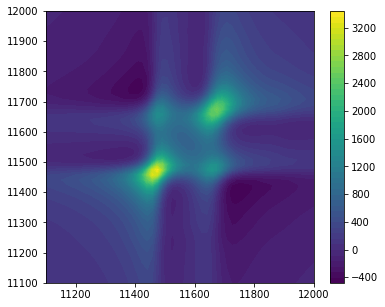

In [31]:
plt.figure(figsize=(6,5))
plt.contourf(f3, f1, X_ftf[:,0,:].real.T, 50)
plt.xlim(11100, 12000)
plt.ylim(11100, 12000)
plt.colorbar();

In [32]:
alpha, beta = np.argmin(np.abs(f1 - np.array([11530, 11730]).reshape(-1,1)), 1)

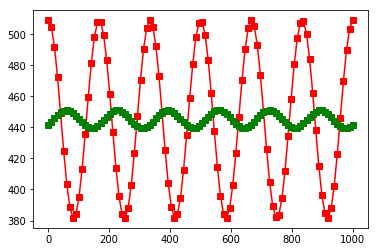

In [33]:
plt.plot(t2, X_ftf[beta, :, alpha].real, '-sr')
plt.plot(t2, X_ftf[alpha, :, beta].real, '-sg');